#        PREDICTING THE ALPHA SIGNAL USING MICROBLOGGING DATA


### PROBLEM STATEMENT:

Predicting the alpha signal values of the different stocks(companies) based on ticker and id using 7 stock factors and also collecting extra information(factor) generated from sentiment analysis of the stocktwits


### PROBLEM DESCRIPTION:

A hedge fund uses 6 financial factors to predict the alpha signal in a stock. This alpha signal is used to make purchase decisions about the stock. The hedge fund now collected and tagged microblogging data for sentiment from the Social Media platform called ‘StockTwits’.

StockTwits is used by people who regularly trade stocks. People on this platform tweet about stocks using the special character ‘$’ to indicate the name of the stock. These microblogs similar to tweets might contain important information about the alpha signal in a stock.

Your goal is to build a sentiment analysis model using the tagged data. This sentiment analysis model should then be used to generate a new stock factor which together with theother stock factors should be used to predict the Alpha Signal.

The hedge fund has anonymyzed the data, which contains 7 stock factors and an alpha signal. This alpha signal is generated using a near perfect algorithmic trading strategy. Unfortunately,the number of stock factors, collected to run that strategy, are extremely high and have to be collected from a large number of data vendors at a high price.

Replicating the alpha signal generated from that strategy using just the 7 Stock Factors and the factor generated from sentiment analysis of the stocktwits would make the company incur significantly less costs to perform their trades.


### JSON DATA

### INDEPENDENT VARIABLES:

1.stocktwit_tweet : The hedge fund now collected and tagged microblogging data for sentiment from the Social Media platform                         called ‘StockTwits’ 

2.timestamp : The date and time at which the factors are generated

3.ticker : The identifier through which the company is listed in the stock exchange

### TARGET VARIABLE OR DEPENDENT VARIABLE:

4.sentiment_score : sentimen score is based on positive, negative, or neutral emotions stimulated by the text

### CSV DATA

### INDEPENDENT VARIABLES:

1.Id : Index or unique identifier for a record, in the individual data file.

2.date : The date at which the factors are generated

3.ticker : The identifier through which the company is listed in the stock exchange

4.SF1 - SF7 : 7 anonymized Stock Factors that can be used to predict.

### TARGET VARIABLE OR DEPENDENT VARIABLE:

5.alpha : The alpha signal generated by using a high performing algorithmic trading strategy. (range: 1 - 4)
 
### EVALUATION METRIC

**The average of the F1-score for each of the classes
      
**Eval Metric = (F1 score for target level 1 + level 2 + level 3 + level 4) / 4
      
**The metric is equivalent to the f1_score() function’s output from sklearn.metrics when it’s argument is set to the string ‘macro’


### IMPORTING LIBRARIES 

In [9]:
##importing libraries
import re
import nltk
import json
import random
import string

import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [10]:
!pip install XGBoost

### PREPROCESSING FOR TRAIN JSON DATA

In [11]:
###reading the train_data json data
train_data=pd.read_json('C:\\Users\\mythr\\OneDrive\\Desktop\\3041\\PHD\\train_data-1573118738755.json')
train_data.head()

,records
0,{'stocktwit_tweet': '$AMD going up but hesitat...
1,{'stocktwit_tweet': '@inforlong @MariaGascon D...
2,"{'stocktwit_tweet': '$AVGO WTF?', 'sentiment_s..."
3,{'stocktwit_tweet': '$PH New Insider Filing O...
4,{'stocktwit_tweet': '$FB if it bounces tommorr...


In [12]:
###converting train_data json to dataframe
from pandas.io.json import json_normalize
with open('C:\\Users\\mythr\\OneDrive\\Desktop\\3041\\PHD\\train_data-1573118738755.json') as f: 
    d = json.load(f) 
    
train_data = json_normalize(d['records']) 
train_data.head(5)     

,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00


In [13]:
###shape(dimension) of the train_data
train_data.shape

(1039131, 4)

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039131 entries, 0 to 1039130
Data columns (total 4 columns):
sentiment_score    1039131 non-null int64
stocktwit_tweet    1039131 non-null object
ticker             1039131 non-null object
timestamp          1039131 non-null object
dtypes: int64(1), object(3)
memory usage: 31.7+ MB


In [15]:
###showing the datatype,no of levels,levels of test_data
def inspect_data(data):
    return pd.DataFrame({"Data Type":data.dtypes,"No of Levels":data.apply(lambda x: x.nunique(),axis=0), "Levels":data.apply(lambda x: str(x.unique()),axis=0)})
inspect_data(train_data)

,Data Type,No of Levels,Levels
sentiment_score,int64,5,[3 2 0 4 1]
stocktwit_tweet,object,959608,['$AMD going up but hesitating however chart i...
ticker,object,2181,['$AMD' '$CAT' '$AVGO' ... '$Baba' '$PIRS' '$$...
timestamp,object,905458,['2018-09-19 18:38:28+00:00' '2018-10-09 03:51...


### CONVERT TIMESTAMP INTO DATE,HOUR,MINUTES,SECONDS

In [16]:
import datetime as dt
train_data['date'] = pd.DatetimeIndex(train_data['timestamp']).date
train_data['hour'] = pd.DatetimeIndex(train_data['timestamp']).hour
train_data['minutes'] = pd.DatetimeIndex(train_data['timestamp']).minute
train_data['seconds'] = pd.DatetimeIndex(train_data['timestamp']).second
train_data.head(5)

,sentiment_score,stocktwit_tweet,ticker,timestamp,date,hour,minutes,seconds
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,2018-09-19,18,38,28
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,2018-10-09,3,51,6
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2018-07-12,13,35,32
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,2018-07-19,3,32,50
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,2018-08-23,19,7,54


In [17]:
###checking number of words in the stocktwit_tweet
train_data["num_words"] = train_data["stocktwit_tweet"].apply(lambda x: len(str(x).split()))

In [18]:
###checking number of unique words
train_data["num_unique_words"] = train_data["stocktwit_tweet"].apply(lambda x: len(set(str(x).split())))

In [19]:
###checking number of stopwords
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))

In [20]:
train_data["num_stopwords"] = train_data["stocktwit_tweet"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

In [21]:
###checking number of punctuations
import string
train_data["num_punctuations"] =train_data['stocktwit_tweet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

In [22]:
train_data.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp,date,hour,minutes,seconds,num_words,num_unique_words,num_stopwords,num_punctuations
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00,2018-09-19,18,38,28,13,12,5,1
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00,2018-10-09,3,51,6,11,11,1,3
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00,2018-07-12,13,35,32,2,2,0,2
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00,2018-07-19,3,32,50,11,11,0,11
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00,2018-08-23,19,7,54,11,11,5,1


In [23]:
###dropping timestamp columns
train_data=train_data.drop(['timestamp','num_words','num_unique_words','num_stopwords','num_punctuations','hour','minutes','seconds'],axis=1)

In [24]:
train_data.head()

,sentiment_score,stocktwit_tweet,ticker,date
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09
2,2,$AVGO WTF?,$AVGO,2018-07-12
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23


### VISUALIZATION

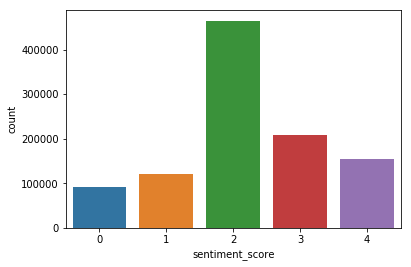

In [25]:
###frequency of sentiment_score
sns.countplot(train_data['sentiment_score'])

In [26]:
###separating stocktwit_tweet from the train_data assiagn variable as tweets
tweets = train_data[["stocktwit_tweet"]]
tweets= tweets["stocktwit_tweet"].astype(str)
tweets.head()

0    $AMD going up but hesitating however chart is ...
1    @inforlong @MariaGascon Despite\nChina trade w...
2                                           $AVGO WTF?
3    $PH\n New Insider Filing On: \n MULLER KLAUS P...
4    $FB if it bounces tommorrow do the right thing...
Name: stocktwit_tweet, dtype: object

### CONVERTING TWEETS INTO LOWERCASE 

In [27]:
###converting tweets into lowercase
tweets= tweets.str.lower()
tweets.head()

0    $amd going up but hesitating however chart is ...
1    @inforlong @mariagascon despite\nchina trade w...
2                                           $avgo wtf?
3    $ph\n new insider filing on: \n muller klaus p...
4    $fb if it bounces tommorrow do the right thing...
Name: stocktwit_tweet, dtype: object

In [28]:
###removing '@' and '$' words in the tweets
tweets=tweets.replace('\$\w+', ' ',regex=True).astype(object)
tweets=tweets.replace('\@\w+', ' ',regex=True).astype(object)
tweets.head(10)

0      going up but hesitating however chart is ver...
1          despite\nchina trade war   held very well 👍
2                                                 wtf?
3     \n new insider filing on: \n muller klaus pet...
4      if it bounces tommorrow do the right thing a...
5                      as usual......red  \nevery day.
6      unitedhealth group goes ex-dividend today ht...
7                    let&#39;s see when we can hit 310
8        i bet you’re also the one saying   should ...
9                                    pastor the stooge
Name: stocktwit_tweet, dtype: object

In [29]:
##removing digits in the tweets
tweets=tweets.replace('[\d]', ' ',regex=True).astype(object)
tweets

0            going up but hesitating however chart is ver...
1                despite\nchina trade war   held very well 👍
2                                                       wtf?
3           \n new insider filing on: \n muller klaus pet...
4            if it bounces tommorrow do the right thing a...
5                            as usual......red  \nevery day.
6            unitedhealth group goes ex-dividend today ht...
7                          let&#  ;s see when we can hit    
8              i bet you’re also the one saying   should ...
9                                          pastor the stooge
10             called it friday hahahaha suckers sold friday
11           exp: /  /    |maxpain:   . |highputoi:   . (...
12           day in, day out this puppy is making people ...
13                                                          
14                                                          
15           earnings august    bmo.   -aug-   straddle i...
16                      

In [30]:
##removing URLs in the tweets
tweets = tweets.replace('http\S+', ' ', regex=True)
tweets

0            going up but hesitating however chart is ver...
1                despite\nchina trade war   held very well 👍
2                                                       wtf?
3           \n new insider filing on: \n muller klaus pet...
4            if it bounces tommorrow do the right thing a...
5                            as usual......red  \nevery day.
6            unitedhealth group goes ex-dividend today   ...
7                          let&#  ;s see when we can hit    
8              i bet you’re also the one saying   should ...
9                                          pastor the stooge
10             called it friday hahahaha suckers sold friday
11           exp: /  /    |maxpain:   . |highputoi:   . (...
12           day in, day out this puppy is making people ...
13                                                          
14                                                          
15           earnings august    bmo.   -aug-   straddle i...
16                      

### REMOVING PUNCTUATIONS 

In [31]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [32]:
#remove punctaitions and special chracters
#tweets = tweets.str.replace('[^\w\s]','')
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(tweets):
    """custom function to remove the punctuation"""
    return tweets.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

tweets= tweets.apply(lambda tweets: remove_punctuation(tweets))
tweets.head()

0      going up but hesitating however chart is ver...
1          despite\nchina trade war   held very well 👍
2                                                  wtf
3     \n new insider filing on \n muller klaus pete...
4      if it bounces tommorrow do the right thing a...
Name: stocktwit_tweet, dtype: object

### REMOVING STOPWORDS

In [33]:
##removing stop words
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [34]:
stopwords=stopwords.words('english')

In [35]:
words=['above','below','up','down','over','under','few','more','most','not','very']
for word in words:
    stopwords.remove(word)
print(stopwords)    

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'to', 'from', 'in', 'out', 'on', 'off', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", '

In [36]:
#STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(tweets):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(tweets).split() if word not in stopwords])
tweets= tweets.apply(lambda tweets: remove_stopwords(tweets))
tweets.head()

0    going up hesitating however chart very stable ...
1             despite china trade war held very well 👍
2                                                  wtf
3    new insider filing muller klaus peter transact...
4                   bounces tommorrow right thing gtfo
Name: stocktwit_tweet, dtype: object

### LEMMATIZATION

In [37]:
##lemmatization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_words(tweets):
    return " ".join([lemmatizer.lemmatize(word) for word in tweets.split()])
tweets = tweets.apply(lambda tweets: lemmatize_words(tweets))
tweets.head()

0    going up hesitating however chart very stable ...
1             despite china trade war held very well 👍
2                                                  wtf
3    new insider filing muller klaus peter transact...
4                    bounce tommorrow right thing gtfo
Name: stocktwit_tweet, dtype: object

In [38]:
##splittng sentences into words
#tweets=tweets.str.split()
#tweets.head()

In [39]:
train_data=train_data.drop(["stocktwit_tweet"],axis=1)
train_data.head()

,sentiment_score,ticker,date
0,3,$AMD,2018-09-19
1,3,$CAT,2018-10-09
2,2,$AVGO,2018-07-12
3,2,$PH,2018-07-19
4,3,$FB,2018-08-23


In [40]:
###concatinating the tweets with train_data
train_data=pd.concat([tweets,train_data],axis=1)
train_data.head()

,stocktwit_tweet,sentiment_score,ticker,date
0,going up hesitating however chart very stable ...,3,$AMD,2018-09-19
1,despite china trade war held very well 👍,3,$CAT,2018-10-09
2,wtf,2,$AVGO,2018-07-12
3,new insider filing muller klaus peter transact...,2,$PH,2018-07-19
4,bounce tommorrow right thing gtfo,3,$FB,2018-08-23


In [41]:
###checking blank spaces
train_data.head(15)

,stocktwit_tweet,sentiment_score,ticker,date
0,going up hesitating however chart very stable ...,3,$AMD,2018-09-19
1,despite china trade war held very well 👍,3,$CAT,2018-10-09
2,wtf,2,$AVGO,2018-07-12
3,new insider filing muller klaus peter transact...,2,$PH,2018-07-19
4,bounce tommorrow right thing gtfo,3,$FB,2018-08-23
5,usualred every day,0,$FB,2018-08-02
6,unitedhealth group go exdividend today ckh uni...,2,$AET,2018-09-07
7,let see hit,4,$NOC,2018-09-12
8,bet you’re also one saying smh,2,$AMZN,2018-10-28
9,pastor stooge,2,$AMD,2018-08-17


### REMOVING BLANK SPACES 

In [42]:
##removing blank spaces in the train_data
train_data.dropna(inplace=True)
blank_space = []
for a,b,c,d,e in train_data.itertuples():
    if type(b) == str:
        if b=="":
            blank_space.append(a)
            
train_data.drop(blank_space,inplace=True)    
train_data.head(15)

,stocktwit_tweet,sentiment_score,ticker,date
0,going up hesitating however chart very stable ...,3,$AMD,2018-09-19
1,despite china trade war held very well 👍,3,$CAT,2018-10-09
2,wtf,2,$AVGO,2018-07-12
3,new insider filing muller klaus peter transact...,2,$PH,2018-07-19
4,bounce tommorrow right thing gtfo,3,$FB,2018-08-23
5,usualred every day,0,$FB,2018-08-02
6,unitedhealth group go exdividend today ckh uni...,2,$AET,2018-09-07
7,let see hit,4,$NOC,2018-09-12
8,bet you’re also one saying smh,2,$AMZN,2018-10-28
9,pastor stooge,2,$AMD,2018-08-17


In [43]:
train_data.shape

(1013808, 4)

Text(0.5, 1.0, 'wordcloud of four sentiment words')

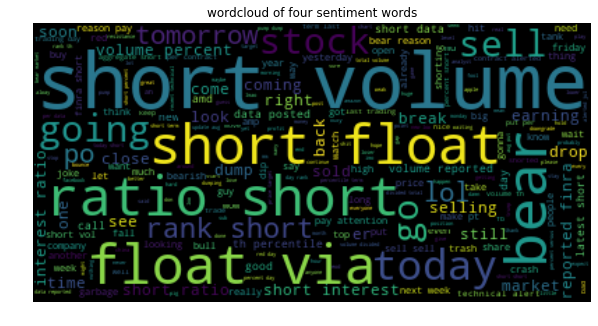

In [44]:
#!pip install WordCloud
from wordcloud import WordCloud
word_four_sentiment=train_data[train_data.sentiment_score==0]

words_four= (' '.join(word_four_sentiment['stocktwit_tweet']))
wordcloud = WordCloud(max_words=10000, 
                      max_font_size=90).generate(words_four)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('wordcloud of four sentiment words')

Text(0.5, 1.0, 'wordcloud of zero sentiment words')

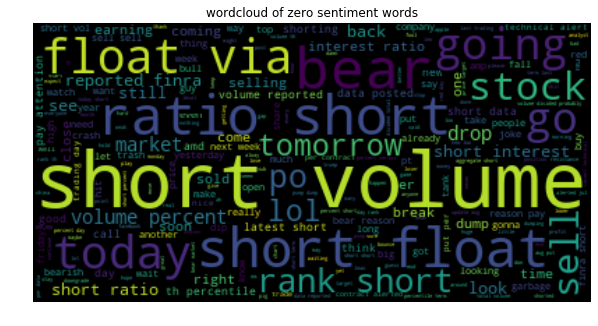

In [45]:
from wordcloud import WordCloud
word_zero_sentiment=train_data[train_data.sentiment_score==0]

words_zero= (' '.join(word_zero_sentiment['stocktwit_tweet']))
wordcloud = WordCloud(max_words=10000, 
                      max_font_size=90).generate(words_zero)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('wordcloud of zero sentiment words')

Text(0.5, 1.0, 'wordcloud of tickers  sentiment 4')

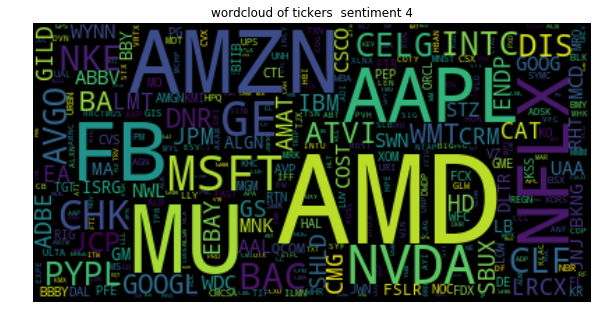

In [46]:
from wordcloud import WordCloud
word_ticker=train_data[train_data.sentiment_score==4]

ticker_words= (' '.join(word_ticker['ticker']))
wordcloud = WordCloud(max_words=10000, 
                      max_font_size=90).generate(ticker_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('wordcloud of tickers  sentiment 4')

Text(0.5, 1.0, 'wordcloud of tickers sentiment 0')

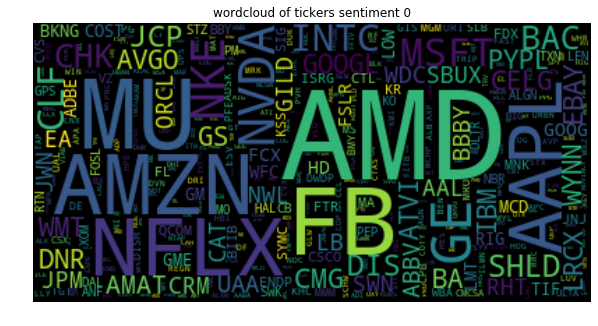

In [47]:
from wordcloud import WordCloud
word_ticker=train_data[train_data.sentiment_score==0]

ticker_words= (' '.join(word_ticker['ticker']))
wordcloud = WordCloud(max_words=10000, 
                      max_font_size=90).generate(ticker_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('wordcloud of tickers sentiment 0')

### TRAIN TEST SPLIT FOR TRAIN JSON DATA

In [48]:
##train,test split
from sklearn.model_selection import train_test_split 
x_train, x_validation, y_train, y_validation=train_test_split(train_data['stocktwit_tweet'],train_data['sentiment_score'],test_size=0.3,random_state=1234)

In [49]:
###checking the shapes of x_train,x_validation,y_train,y_validation
print(x_train.shape)
print(x_validation.shape)
print(y_train.shape)
print(y_validation.shape)

(709665,)
(304143,)
(709665,)
(304143,)


In [50]:
x_train.head()

681498    justice buying ramp get ran lower terrible tra...
648744    analyst day not catalyst hoped earnings not ca...
232167                                  shaq kitty approved
712747    estimize revenue expectation higher wall stree...
230806                               gm stock may fall much
Name: stocktwit_tweet, dtype: object

In [51]:
###checking the indexes of the x_train
x_train_indexes=np.array(x_train.index)
x_train_indexes

array([681498, 648744, 232167, ..., 169276, 462436, 498222], dtype=int64)

In [52]:
###checking the indexes of the x_validation
x_validation_indexes=np.array(x_validation.index)
x_validation_indexes

array([328378, 362755, 353466, ...,  76667, 174041,  75448], dtype=int64)

### TF-IDF 

In [53]:
#Lets construct TF-IDF matrix based on the x_train,x_validation
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_transformer = TfidfVectorizer(ngram_range=(1,1),max_df=4.0,min_df=4,norm='l2',encoding=string,decode_error='strict',preprocessor=None)
x_train_tfidf = tfidf_transformer.fit_transform(x_train)
x_validation_tfidf = tfidf_transformer.transform(x_validation)
x_train_tfidf.shape
x_validation_tfidf.shape

(304143, 23758)

In [54]:
x_train_tfidf

<709665x23758 sparse matrix of type '<class 'numpy.float64'>'
	with 4470192 stored elements in Compressed Sparse Row format>

### COUNTVECTORIZER 

In [55]:
#Lets construct CountVectorizer matrix based on the x_train,x_validation
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(stop_words='english',lowercase=True,strip_accents='unicode',decode_error='ignore')
x_train_cv = cv.fit_transform(x_train)
x_validation_cv = cv.transform(x_validation)
x_train_cv.shape
x_validation_cv.shape

(304143, 129423)

### MODEL BUILDING FOR TRAIN JSON DATA 

#### MODEL 1(A): MULTINOMIAL NAIVE BAYES WITH TF-IDF

In [56]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

nb_clf = MultinomialNB().fit(x_train_tfidf, y_train) #nb_clf is the classifier
pred_train_nb_tfidf = nb_clf.predict(x_train_tfidf) #get predictions on train data
pred_validation_nb_tfidf = nb_clf.predict(x_validation_tfidf) #predict on test data

print(classification_report(y_train, pred_train_nb_tfidf)) 
print(classification_report(y_validation,pred_validation_nb_tfidf))
print("train Accuracy is ",accuracy_score(y_train, pred_train_nb_tfidf))
print("validation Accuracy is ",accuracy_score(y_validation,pred_validation_nb_tfidf))

#prediction = confusion_matrix(y_validation,pred_validation_nb_tfidf) ##get confusion matrix for test predictions

              precision    recall  f1-score   support

           0       0.76      0.35      0.48     63654
           1       0.66      0.27      0.39     83617
           2       0.63      0.88      0.73    313761
           3       0.45      0.40      0.42    142176
           4       0.61      0.48      0.54    106457

   micro avg       0.60      0.60      0.60    709665
   macro avg       0.62      0.47      0.51    709665
weighted avg       0.61      0.60      0.58    709665

              precision    recall  f1-score   support

           0       0.74      0.33      0.45     27200
           1       0.64      0.26      0.37     35870
           2       0.62      0.87      0.72    134431
           3       0.43      0.37      0.39     61221
           4       0.59      0.46      0.51     45421

   micro avg       0.59      0.59      0.59    304143
   macro avg       0.60      0.46      0.49    304143
weighted avg       0.59      0.59      0.56    304143

train Accuracy is  0.6

([0.410675534763126,
  0.39862470320503335,
  0.3932756847143481,
  0.39282971542911094,
  0.3927802452991838,
  0.39358476652129293,
  0.39426690688756255,
  0.3954647615424179,
  0.39625769925692583,
  0.39710144927536234],
 [0.45637085186902215,
  0.43924403981022087,
  0.42915667958822,
  0.4239321634888852,
  0.4205949175223497,
  0.4181026688103951,
  0.41668557224726527,
  0.4150909276228616,
  0.4140979736505525,
  0.4131609144382741])

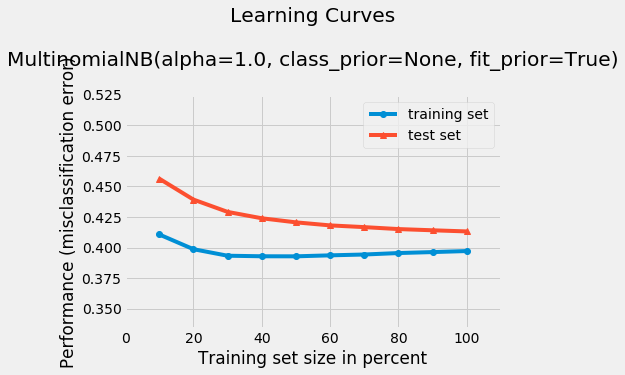

In [57]:
#!pip install mlxtend
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(x_train_tfidf, y_train,x_validation_tfidf,y_validation,nb_clf)

from sklearn.model_selection import learning_curve
train_size, train_score, test_score = learning_curve(estimator=nb_clf, X=x_train), y=y_train, cv=10 )

train_score_m = np.mean(train_score, axis=1)
test_score_m = np.mean(test_score, axis=1)

plt.plot(train_size, train_score_m, 'o-', color="b")
plt.plot(train_size, test_score_m, 'o-', color="r")
plt.legend(('Training score', 'Test score'), loc='best')
plt.xlabel("Training Samples")
plt.ylabel("Score")
plt.title("Learning Curve for RF")
plt.grid()

plt.show()

In [58]:
###predictions of x_train_nb_tfidf
pred_train_nb_tfidf

array([2, 2, 2, ..., 0, 2, 2], dtype=int64)

In [59]:
###converting pred_train_nb_tfidf to dataframe with x_train_indexes
train_predictions_nb_tfidf=pd.DataFrame(pred_train_nb_tfidf,columns=["SF8"],index=x_train_indexes)
train_predictions_nb_tfidf.head()

,SF8
681498,2
648744,2
232167,2
712747,2
230806,2


In [60]:
###predictions of x_validation_nb_tfidf
pred_validation_nb_tfidf

array([4, 3, 1, ..., 3, 2, 2], dtype=int64)

In [61]:
###converting pred_validation_nb_tfidf to dataframe with x_validation_indexes
validation_predictions_nb_tfidf=pd.DataFrame(pred_validation_nb_tfidf,columns=["SF8"],index=x_validation_indexes)
validation_predictions_nb_tfidf.head()

,SF8
328378,4
362755,3
353466,1
325627,2
860023,2


In [62]:
###concatinating train_predictions_nb_tfidf,validation_predictions_nb_tfidf
predictions_nb_tfidf=pd.concat([train_predictions_nb_tfidf,validation_predictions_nb_tfidf])
predictions_nb_tfidf.head()

,SF8
681498,2
648744,2
232167,2
712747,2
230806,2


In [63]:
###merging train_data,predictions_nb_tfidf with the help of indexes
train_final_tfidf=pd.merge(train_data,predictions_nb_tfidf,how='inner',left_index=True,right_index=True)
train_final_tfidf.head()

,stocktwit_tweet,sentiment_score,ticker,date,SF8
0,going up hesitating however chart very stable ...,3,$AMD,2018-09-19,4
1,despite china trade war held very well 👍,3,$CAT,2018-10-09,2
2,wtf,2,$AVGO,2018-07-12,2
3,new insider filing muller klaus peter transact...,2,$PH,2018-07-19,2
4,bounce tommorrow right thing gtfo,3,$FB,2018-08-23,2


In [64]:
###removing '$' symbol and conerting lowercase for ticker column in the train_final data
train_final_tfidf["ticker"]=train_final_tfidf["ticker"].apply(lambda x: x.replace('$','')).str.lower()
train_final_tfidf.head()

,stocktwit_tweet,sentiment_score,ticker,date,SF8
0,going up hesitating however chart very stable ...,3,amd,2018-09-19,4
1,despite china trade war held very well 👍,3,cat,2018-10-09,2
2,wtf,2,avgo,2018-07-12,2
3,new insider filing muller klaus peter transact...,2,ph,2018-07-19,2
4,bounce tommorrow right thing gtfo,3,fb,2018-08-23,2


In [65]:
train_final_tfidf.shape

(1013808, 5)

In [66]:
train_data.shape

(1013808, 4)

#### MODEL 1(B): MULTINOMIAL NAIVE BAYES WITH COUNTVECTORIZER 

In [67]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

nb_clf = MultinomialNB().fit(x_train_cv, y_train) #nb_clf is the classifier
pred_train_nb_cv = nb_clf.predict(x_train_cv) #get predictions on train data
pred_validation_nb_cv = nb_clf.predict(x_validation_cv) #predict on test data

print(classification_report(y_train, pred_train_nb_cv)) 
print(classification_report(y_validation,pred_validation_nb_cv))
print("train Accuracy is ",accuracy_score(y_train, pred_train_nb_cv))
print("validation Accuracy is ",accuracy_score(y_validation,pred_validation_nb_cv))

prediction = confusion_matrix(y_validation,pred_validation_nb_cv) ##get confusion matrix for test predictions

              precision    recall  f1-score   support

           0       0.64      0.52      0.57     63654
           1       0.62      0.35      0.45     83617
           2       0.73      0.78      0.75    313761
           3       0.46      0.50      0.48    142176
           4       0.57      0.63      0.60    106457

   micro avg       0.63      0.63      0.63    709665
   macro avg       0.60      0.56      0.57    709665
weighted avg       0.63      0.63      0.62    709665

              precision    recall  f1-score   support

           0       0.59      0.46      0.52     27200
           1       0.56      0.30      0.39     35870
           2       0.69      0.76      0.72    134431
           3       0.39      0.43      0.41     61221
           4       0.53      0.58      0.55     45421

   micro avg       0.58      0.58      0.58    304143
   macro avg       0.55      0.50      0.52    304143
weighted avg       0.58      0.58      0.58    304143

train Accuracy is  0.6

([0.3829157624778063,
  0.36573594583359753,
  0.3603492735992184,
  0.3601840304932609,
  0.3618360238084502,
  0.364871688284848,
  0.36743731945688607,
  0.3695634559968436,
  0.37131320279694,
  0.3732845779346593],
 [0.447983349937365,
  0.4303304695488635,
  0.4218706332218726,
  0.41828021687166894,
  0.41646856906126395,
  0.41648172076950646,
  0.4158241353573812,
  0.41555781326547053,
  0.4154098565477423,
  0.4155939804631374])

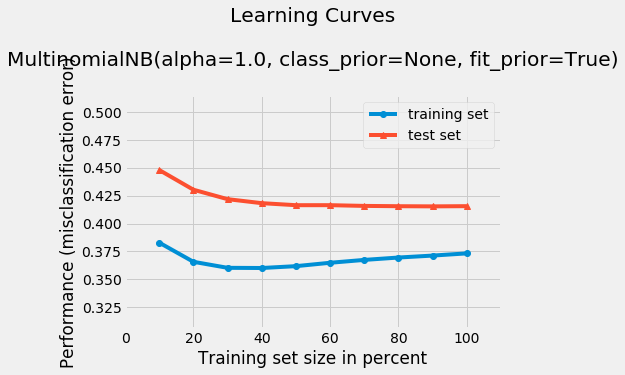

In [68]:
####LEARNING CURVE
#!pip install mlxtend
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(x_train_cv, y_train,x_validation_cv,y_validation,nb_clf)

In [69]:
###predictions of x_train_nb_cv
pred_train_nb_cv

array([1, 2, 2, ..., 0, 2, 2], dtype=int64)

In [70]:
###converting pred_train_nb_tfidf to dataframe with x_train_indexes
train_predictions_nb_cv=pd.DataFrame(pred_train_nb_cv,columns=["SF8"],index=x_train_indexes)
train_predictions_nb_cv.head()

,SF8
681498,1
648744,2
232167,2
712747,2
230806,1


In [71]:
###predictions of x_validation_nb_cv
pred_validation_nb_cv

array([4, 3, 1, ..., 3, 2, 2], dtype=int64)

In [72]:
###converting pred_validation_nb_cv to dataframe with x_validation_indexes
validation_predictions_nb_cv=pd.DataFrame(pred_validation_nb_cv,columns=["SF8"],index=x_validation_indexes)
validation_predictions_nb_cv.head()

,SF8
328378,4
362755,3
353466,1
325627,2
860023,0


In [73]:
###concatinating train_predictions_nb_cv,validation_predictions_nb_cv
predictions_nb_cv=pd.concat([train_predictions_nb_cv,validation_predictions_nb_cv])
predictions_nb_cv.head()

,SF8
681498,1
648744,2
232167,2
712747,2
230806,1


In [74]:
###merging train_data,predictions_nb_cv with the help of indexes
train_final_cv=pd.merge(train_data,predictions_nb_cv,how='inner',left_index=True,right_index=True)
train_final_cv.head()

,stocktwit_tweet,sentiment_score,ticker,date,SF8
0,going up hesitating however chart very stable ...,3,$AMD,2018-09-19,4
1,despite china trade war held very well 👍,3,$CAT,2018-10-09,2
2,wtf,2,$AVGO,2018-07-12,2
3,new insider filing muller klaus peter transact...,2,$PH,2018-07-19,2
4,bounce tommorrow right thing gtfo,3,$FB,2018-08-23,3


In [75]:
###removing '$' symbol and conerting lowercase for ticker column in the train_final data
train_final_cv["ticker"]=train_final_cv["ticker"].apply(lambda x: x.replace('$','')).str.lower()
train_final_cv.head()

,stocktwit_tweet,sentiment_score,ticker,date,SF8
0,going up hesitating however chart very stable ...,3,amd,2018-09-19,4
1,despite china trade war held very well 👍,3,cat,2018-10-09,2
2,wtf,2,avgo,2018-07-12,2
3,new insider filing muller klaus peter transact...,2,ph,2018-07-19,2
4,bounce tommorrow right thing gtfo,3,fb,2018-08-23,3


In [76]:
###removing '$' symbol and conerting lowercase for ticker column in the train_data
train_data["ticker"]=train_data["ticker"].apply(lambda x: x.replace('$','')).str.lower()
train_data.head()

,stocktwit_tweet,sentiment_score,ticker,date
0,going up hesitating however chart very stable ...,3,amd,2018-09-19
1,despite china trade war held very well 👍,3,cat,2018-10-09
2,wtf,2,avgo,2018-07-12
3,new insider filing muller klaus peter transact...,2,ph,2018-07-19
4,bounce tommorrow right thing gtfo,3,fb,2018-08-23


### MODEL 2: LOGISTIC REGRESSION 

In [77]:
from sklearn import linear_model

log = linear_model.LogisticRegression()
log_clf = log.fit(x_train_tfidf, y_train)#fit logreg model on train data

pred_log_train_tfidf=log_clf.predict(x_train_tfidf) # predict on train data
pred_log_validation_tfidf=log_clf.predict(x_validation_tfidf) # predict on test data


print(classification_report(y_train, pred_log_train_tfidf)) 
print(classification_report(y_validation,pred_log_validation_tfidf))
print("train Accuracy is ",accuracy_score(y_train, pred_log_train_tfidf))
print("validation Accuracy is ",accuracy_score(y_validation,pred_log_validation_tfidf))

              precision    recall  f1-score   support

           0       0.68      0.52      0.59     63654
           1       0.62      0.42      0.50     83617
           2       0.68      0.88      0.77    313761
           3       0.57      0.40      0.47    142176
           4       0.67      0.61      0.64    106457

   micro avg       0.66      0.66      0.66    709665
   macro avg       0.64      0.57      0.59    709665
weighted avg       0.65      0.66      0.64    709665

              precision    recall  f1-score   support

           0       0.65      0.50      0.57     27200
           1       0.60      0.41      0.48     35870
           2       0.67      0.88      0.76    134431
           3       0.56      0.38      0.45     61221
           4       0.65      0.59      0.62     45421

   micro avg       0.65      0.65      0.65    304143
   macro avg       0.63      0.55      0.58    304143
weighted avg       0.64      0.65      0.63    304143

train Accuracy is  0.6

([0.3286644308542119,
  0.33377720473744654,
  0.33493816316657193,
  0.3365249800962426,
  0.33754283717364836,
  0.338114932162828,
  0.33904763821927875,
  0.339473554423566,
  0.34012788516638537,
  0.34072555360627904],
 [0.3737288052001854,
  0.36404914793370224,
  0.3602055611998303,
  0.3575949471136932,
  0.35645074849659536,
  0.35462266105088724,
  0.35400453076348953,
  0.35331077815369744,
  0.3527485426263304,
  0.3527485426263304])

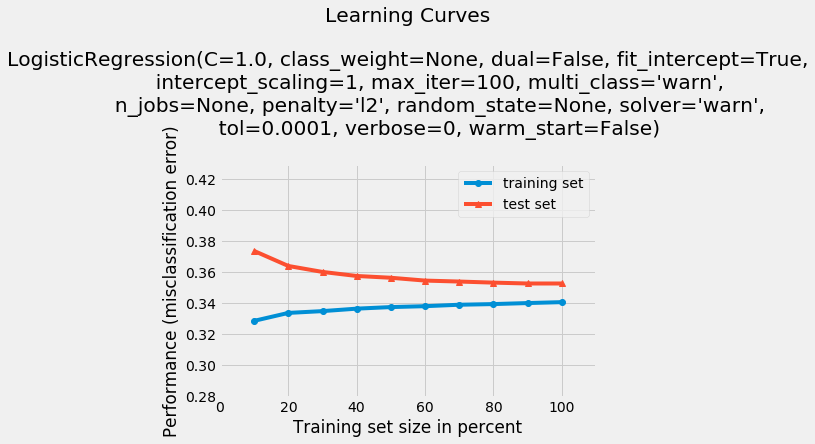

In [78]:
####LEARNING CURVE
#!pip install mlxtend
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(x_train_tfidf, y_train,x_validation_tfidf,y_validation,log)

In [79]:
#from sklearn.svm import SVC

## Create an SVC object and print it to see the default arguments
#svc = SVC()
#print(svc)

## Fit
#svc.fit(x_train_tfidf, y_train)

## Predict
#train_predictions = svc.predict(x_train_tfidf)
#validation_predictions = svc.predict(x_validation_tfidf)

### Train data accuracy
#from sklearn.metrics import accuracy_score
#print(accuracy_score(y_train,train_predictions)
      
### Test data accuracy
#print(accuracy_score(y_validation,validation_predictions))

### PREPROCESSING OF TEST JSON DATA 

In [80]:
###reading the test json data
test_data=pd.read_json('C:\\Users\\mythr\\OneDrive\\Desktop\\3041\\PHD\\test_data.json')
test_data.head()

,records
0,{'stocktwit_tweet': '$CELG nothing to be exite...
1,{'stocktwit_tweet': '$AMD yall exhaust your bu...
2,"{'stocktwit_tweet': '$AMD day traders day.', '..."
3,{'stocktwit_tweet': '$CBS https://tenor.com/wL...
4,{'stocktwit_tweet': '$MU weak price action so ...


In [81]:
###converting given json data to dataframe
from pandas.io.json import json_normalize
with open('C:\\Users\\mythr\\OneDrive\\Desktop\\3041\\PHD\\test_data.json') as f: 
    d = json.load(f) 
test_data = json_normalize(d['records']) 
test_data.head(5)    

,stocktwit_tweet,ticker,timestamp
0,$CELG nothing to be exited about,$CELG,2018-10-25 14:26:16+00:00
1,$AMD yall exhaust your buyer on first green ca...,$AMD,2018-07-13 13:50:39+00:00
2,$AMD day traders day.,$AMD,2018-09-25 19:10:54+00:00
3,$CBS https://tenor.com/wLB8.gif,$CBS,2018-07-27 22:45:48+00:00
4,$MU weak price action so far today. Don’t be a...,$MU,2018-07-31 14:59:06+00:00


In [82]:
test_data.info()##giving the information of the train_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265022 entries, 0 to 265021
Data columns (total 3 columns):
stocktwit_tweet    265022 non-null object
ticker             265022 non-null object
timestamp          265022 non-null object
dtypes: object(3)
memory usage: 6.1+ MB


In [83]:
test_data.columns###total columns in the test_data

Index(['stocktwit_tweet', 'ticker', 'timestamp'], dtype='object')

In [84]:
###showing the datatype,no of levels,levels of test_data
def inspect_data(data):
    return pd.DataFrame({"Data Type":data.dtypes,"No of Levels":data.apply(lambda x: x.nunique(),axis=0), "Levels":data.apply(lambda x: str(x.unique()),axis=0)})
inspect_data(test_data)

,Data Type,No of Levels,Levels
stocktwit_tweet,object,252890,['$CELG nothing to be exited about'\n '$AMD ya...
ticker,object,1444,['$CELG' '$AMD' '$CBS' ... '$BAP' '$tlry' '$NOG']
timestamp,object,254753,['2018-10-25 14:26:16+00:00' '2018-07-13 13:50...


### CONVERTING TIMESTAMP INTO DATE,HOUR,MINUTES,SECONDS 

In [85]:
import datetime as dt
test_data['date'] = pd.DatetimeIndex(test_data['timestamp']).date
test_data['hour'] = pd.DatetimeIndex(test_data['timestamp']).hour
test_data['minutes'] = pd.DatetimeIndex(test_data['timestamp']).minute
test_data['seconds'] = pd.DatetimeIndex(test_data['timestamp']).second
test_data.head(5)

,stocktwit_tweet,ticker,timestamp,date,hour,minutes,seconds
0,$CELG nothing to be exited about,$CELG,2018-10-25 14:26:16+00:00,2018-10-25,14,26,16
1,$AMD yall exhaust your buyer on first green ca...,$AMD,2018-07-13 13:50:39+00:00,2018-07-13,13,50,39
2,$AMD day traders day.,$AMD,2018-09-25 19:10:54+00:00,2018-09-25,19,10,54
3,$CBS https://tenor.com/wLB8.gif,$CBS,2018-07-27 22:45:48+00:00,2018-07-27,22,45,48
4,$MU weak price action so far today. Don’t be a...,$MU,2018-07-31 14:59:06+00:00,2018-07-31,14,59,6


In [86]:
###checking number of words in the stocktwit_tweet
test_data["num_words"] = test_data["stocktwit_tweet"].apply(lambda x: len(str(x).split()))

In [87]:
###checking number of unique words
test_data["num_unique_words"] = test_data["stocktwit_tweet"].apply(lambda x: len(set(str(x).split())))

In [88]:
###checking number of stopwords
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))

In [89]:
test_data["num_stopwords"] = test_data["stocktwit_tweet"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

In [90]:
###checking number of punctuations
import string
test_data["num_punctuations"] =test_data['stocktwit_tweet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

In [91]:
test_data.head()

,stocktwit_tweet,ticker,timestamp,date,hour,minutes,seconds,num_words,num_unique_words,num_stopwords,num_punctuations
0,$CELG nothing to be exited about,$CELG,2018-10-25 14:26:16+00:00,2018-10-25,14,26,16,6,6,3,1
1,$AMD yall exhaust your buyer on first green ca...,$AMD,2018-07-13 13:50:39+00:00,2018-07-13,13,50,39,10,10,2,5
2,$AMD day traders day.,$AMD,2018-09-25 19:10:54+00:00,2018-09-25,19,10,54,4,4,0,2
3,$CBS https://tenor.com/wLB8.gif,$CBS,2018-07-27 22:45:48+00:00,2018-07-27,22,45,48,2,2,0,7
4,$MU weak price action so far today. Don’t be a...,$MU,2018-07-31 14:59:06+00:00,2018-07-31,14,59,6,21,21,4,3


In [92]:
###dropping unwanted columns
test_data=test_data.drop(['timestamp','num_words','num_unique_words','num_stopwords','num_punctuations','hour','minutes','seconds'],axis=1)
test_data.head()

,stocktwit_tweet,ticker,date
0,$CELG nothing to be exited about,$CELG,2018-10-25
1,$AMD yall exhaust your buyer on first green ca...,$AMD,2018-07-13
2,$AMD day traders day.,$AMD,2018-09-25
3,$CBS https://tenor.com/wLB8.gif,$CBS,2018-07-27
4,$MU weak price action so far today. Don’t be a...,$MU,2018-07-31


In [93]:
### separating stocktwit_tweet from test_data as tweets_test
tweets_test = test_data[["stocktwit_tweet"]]
tweets_test= tweets_test["stocktwit_tweet"].astype(str)
tweets_test.head()

0                     $CELG nothing to be exited about
1    $AMD yall exhaust your buyer on first green ca...
2                                $AMD day traders day.
3                      $CBS https://tenor.com/wLB8.gif
4    $MU weak price action so far today. Don’t be a...
Name: stocktwit_tweet, dtype: object

### CONVERTING TO LOWERCASE 

In [94]:
###converting into lowercase
tweets_test= tweets_test.str.lower()
tweets_test.head()

0                     $celg nothing to be exited about
1    $amd yall exhaust your buyer on first green ca...
2                                $amd day traders day.
3                      $cbs https://tenor.com/wlb8.gif
4    $mu weak price action so far today. don’t be a...
Name: stocktwit_tweet, dtype: object

In [95]:
###removing @,$ symbols in the tweets_test
tweets_test=tweets_test.replace('\$\w+', ' ',regex=True).astype(object)
tweets_test=tweets_test.replace('\@\w+', ' ',regex=True).astype(object)
tweets_test.head()

0                           nothing to be exited about
1      yall exhaust your buyer on first green candl...
2                                     day traders day.
3                           https://tenor.com/wlb8.gif
4      weak price action so far today. don’t be afr...
Name: stocktwit_tweet, dtype: object

In [96]:
##removing digits
tweets_test=tweets_test.replace('[\d]', ' ',regex=True).astype(object)

In [97]:
##removing URLs in the tweets
tweets_test = tweets_test.replace('http\S+', ' ', regex=True)
tweets_test.head()

0                           nothing to be exited about
1      yall exhaust your buyer on first green candl...
2                                     day traders day.
3                                                 .gif
4      weak price action so far today. don’t be afr...
Name: stocktwit_tweet, dtype: object

### REMOVING PUNCTUATIONS TEST JSON 

In [98]:
#remove punctaitions and special chracters
#tweets = tweets.str.replace('[^\w\s]','')
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(tweets_test):
    """custom function to remove the punctuation"""
    return tweets_test.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

tweets_test= tweets_test.apply(lambda tweets_test: remove_punctuation(tweets_test))
tweets_test.head()

0                           nothing to be exited about
1      yall exhaust your buyer on first green candl...
2                                      day traders day
3                                                  gif
4      weak price action so far today don’t be afra...
Name: stocktwit_tweet, dtype: object

### REMOVING STOPWORDS FOR TEST JSON 

In [99]:
##removing stop words
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [100]:
stopwords=stopwords.words('english')

In [101]:
words=['above','below','up','down','over','under','few','more','most','not','very']
for word in words:
    stopwords.remove(word)
print(stopwords)    

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'to', 'from', 'in', 'out', 'on', 'off', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", '

In [102]:
#STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(tweets_test):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(tweets_test).split() if word not in stopwords])
tweets_test= tweets_test.apply(lambda tweets_test: remove_stopwords(tweets_test))
tweets_test.head()

0                                       nothing exited
1       yall exhaust buyer first green candle byeeeeee
2                                      day traders day
3                                                  gif
4    weak price action far today don’t afraid go sh...
Name: stocktwit_tweet, dtype: object

### LEMMATIZTION 

In [103]:
##lemmatization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_words(tweets_test):
    return " ".join([lemmatizer.lemmatize(word) for word in tweets_test.split()])
tweets_test = tweets_test.apply(lambda tweets_test: lemmatize_words(tweets_test))
tweets_test.head()

0                                       nothing exited
1       yall exhaust buyer first green candle byeeeeee
2                                       day trader day
3                                                  gif
4    weak price action far today don’t afraid go sh...
Name: stocktwit_tweet, dtype: object

In [104]:
test_data=test_data.drop(["stocktwit_tweet"],axis=1)

In [105]:
###concatinating tweets_test to the test_data
test_data=pd.concat([tweets_test,test_data],axis=1)
test_data.head()

,stocktwit_tweet,ticker,date
0,nothing exited,$CELG,2018-10-25
1,yall exhaust buyer first green candle byeeeeee,$AMD,2018-07-13
2,day trader day,$AMD,2018-09-25
3,gif,$CBS,2018-07-27
4,weak price action far today don’t afraid go sh...,$MU,2018-07-31


In [106]:
##removing blank spaces
test_data.dropna(inplace=True)
blank_space = []
for a,b,c,d in test_data.itertuples():
    if type(b) == str:
        if b=="":
            blank_space.append(a)
test_data.drop(blank_space,inplace=True)
test_data.head()

,stocktwit_tweet,ticker,date
0,nothing exited,$CELG,2018-10-25
1,yall exhaust buyer first green candle byeeeeee,$AMD,2018-07-13
2,day trader day,$AMD,2018-09-25
3,gif,$CBS,2018-07-27
4,weak price action far today don’t afraid go sh...,$MU,2018-07-31


In [107]:
test_data.shape

(258603, 3)

In [108]:
###taking stocktwit_tweet from test_data
test_data1=test_data['stocktwit_tweet']

In [109]:
test_data1.head()

0                                       nothing exited
1       yall exhaust buyer first green candle byeeeeee
2                                       day trader day
3                                                  gif
4    weak price action far today don’t afraid go sh...
Name: stocktwit_tweet, dtype: object

In [110]:
type(test_data1)

pandas.core.series.Series

### TF-IDF

In [111]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#tfidf_transformer = TfidfVectorizer(ngram_range=(1,1),max_df=4.0,min_df=4,norm='l2',encoding=string,decode_error='strict',preprocessor=None)
test_data_tfidf = tfidf_transformer.transform(test_data1)
test_data_tfidf.shape

(258603, 23758)

### COUNTVECTORIZER 

In [112]:
test_data_cv = cv.transform(test_data1)

### TEST JSON PREDICTIONS FOR THE MULTINOMIAL NAIVE BAYES WITH TF-IDF

In [113]:
#from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB().fit(x_train_tfidf, y_train) #nb_clf is the classifier
pred_test_nb_tfidf = nb_clf.predict(test_data_tfidf) #get predictions on test data
pred_test_nb_tfidf

array([2, 3, 2, ..., 3, 2, 3], dtype=int64)

In [114]:
###indexes of the pred_test_nb_tfidf
test_indexes=np.array(test_data1.index)
test_indexes

array([     0,      1,      2, ..., 265019, 265020, 265021], dtype=int64)

In [115]:
###converting to dataframe
test_predictions=pd.DataFrame(pred_test_nb_tfidf,columns=["SF8"],index=test_indexes)
test_predictions.head()

,SF8
0,2
1,3
2,2
3,2
4,3


In [116]:
###merging test predictions to test_data
test_final=pd.merge(test_data,test_predictions,how='inner',left_index=True,right_index=True)
test_final.head()

,stocktwit_tweet,ticker,date,SF8
0,nothing exited,$CELG,2018-10-25,2
1,yall exhaust buyer first green candle byeeeeee,$AMD,2018-07-13,3
2,day trader day,$AMD,2018-09-25,2
3,gif,$CBS,2018-07-27,2
4,weak price action far today don’t afraid go sh...,$MU,2018-07-31,3


In [117]:
###removing '$' symbols and converting to lowercase of the ticker
test_final["ticker"]=test_final["ticker"].apply(lambda x: x.replace('$','')).str.lower()
test_final.head()

,stocktwit_tweet,ticker,date,SF8
0,nothing exited,celg,2018-10-25,2
1,yall exhaust buyer first green candle byeeeeee,amd,2018-07-13,3
2,day trader day,amd,2018-09-25,2
3,gif,cbs,2018-07-27,2
4,weak price action far today don’t afraid go sh...,mu,2018-07-31,3


###  TEST JSON PREDICTIONS FOR THE MULTINOMIAL NAIVE BAYES WITH COUNTVECTORIZER

In [118]:
#from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB().fit(x_train_cv, y_train) #nb_clf is the classifier
pred_test_nb_cv = nb_clf.predict(test_data_cv) #get predictions on test data
pred_test_nb_cv

array([2, 4, 2, ..., 3, 2, 3], dtype=int64)

In [119]:
###indexes of the pred_test_nb_tfidf
test_indexes=np.array(test_data1.index)
test_indexes

array([     0,      1,      2, ..., 265019, 265020, 265021], dtype=int64)

In [120]:
###converting to dataframe
test_predictions_cv=pd.DataFrame(pred_test_nb_cv,columns=["SF8"],index=test_indexes)
test_predictions_cv.head()

,SF8
0,2
1,4
2,2
3,2
4,3


In [121]:
###merging test predictions to test_data
test_final_cv=pd.merge(test_data,test_predictions_cv,how='inner',left_index=True,right_index=True)
test_final_cv.head()

,stocktwit_tweet,ticker,date,SF8
0,nothing exited,$CELG,2018-10-25,2
1,yall exhaust buyer first green candle byeeeeee,$AMD,2018-07-13,4
2,day trader day,$AMD,2018-09-25,2
3,gif,$CBS,2018-07-27,2
4,weak price action far today don’t afraid go sh...,$MU,2018-07-31,3


In [122]:
###removing '$' symbols and converting to lowercase of the ticker
test_final_cv["ticker"]=test_final_cv["ticker"].apply(lambda x: x.replace('$','')).str.lower()
test_final_cv.head()

,stocktwit_tweet,ticker,date,SF8
0,nothing exited,celg,2018-10-25,2
1,yall exhaust buyer first green candle byeeeeee,amd,2018-07-13,4
2,day trader day,amd,2018-09-25,2
3,gif,cbs,2018-07-27,2
4,weak price action far today don’t afraid go sh...,mu,2018-07-31,3


### PREPROCESSING ON TRAIN_FACTORS DATA(CSV)

In [123]:
###reading the train_factors data
train_factors=pd.read_csv("C:\\Users\\mythr\\OneDrive\\Desktop\\3041\\PHD\\train_factors-1573207730757.csv")
train_factors.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,21/08/18,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,11/10/18,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,21/08/18,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1
3,4,10/07/18,$ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2
4,5,12/09/18,$FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2


In [124]:
train_factors.shape###shape(dimension) of the data

(27006, 11)

In [125]:
train_factors.describe()

,Id,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
count,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000
mean,13503.500000,0.005429,-0.001005,-0.024421,-0.042420,0.041465,0.002597,0.036744,2.379582
std,7796.105021,0.941853,0.996130,0.539555,1.111309,0.976028,0.998839,1.204473,1.008681
min,1.000000,-4.114670,-4.578587,-2.609150,-6.329798,-5.480268,-4.338751,-5.347869,1.000000
25%,6752.250000,-0.596792,-0.666310,-0.300187,-0.767247,-0.518641,-0.668027,-0.688198,2.000000
50%,13503.500000,0.012104,-0.013257,-0.040786,-0.058629,0.072127,0.007417,0.081374,2.000000
75%,20254.750000,0.611574,0.669094,0.241424,0.677433,0.616538,0.674592,0.807556,3.000000
max,27006.000000,4.415048,3.822270,3.452486,4.907407,4.779911,4.075428,5.182912,4.000000


In [126]:
train_factors.info()###information of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27006 entries, 0 to 27005
Data columns (total 11 columns):
Id        27006 non-null int64
date      27006 non-null object
ticker    27006 non-null object
SF1       27006 non-null float64
SF2       27006 non-null float64
SF3       27006 non-null float64
SF4       27006 non-null float64
SF5       27006 non-null float64
SF6       27006 non-null float64
SF7       27006 non-null float64
alpha     27006 non-null int64
dtypes: float64(7), int64(2), object(2)
memory usage: 2.3+ MB


In [127]:
###shows the datatypes,no of levels,levels of the train_factors data
def inspect_data(data):
    return pd.DataFrame({"Data Type":data.dtypes,"No of Levels":data.apply(lambda x: x.nunique(),axis=0), "Levels":data.apply(lambda x: str(x.unique()),axis=0)})
inspect_data(train_factors)

,Data Type,No of Levels,Levels
Id,int64,27006,[1 2 3 ... 27004 27005 27006]
date,object,123,['21/08/18' '11/10/18' '10/07/18' '12/09/18' '...
ticker,object,1304,['$NTAP' '$WYNN' '$DRI' ... '$GEVO' '$QTM' '$a...
SF1,float64,26703,[-0.628651934 1.315785931 -1.141388142 ... 1.3...
SF2,float64,26703,[0.98889147 1.4387540019999998 -1.455015676999...
SF3,float64,26703,[-0.055714478 0.18732718199999998 0.332754543 ...
SF4,float64,26703,[0.774378771 0.608933159 0.674501682 ... -0.27...
SF5,float64,26703,[0.551088847 -1.153029724 0.11132613699999999 ...
SF6,float64,26703,[-1.329228593 1.85944112 -0.478596905 ... -1.5...
SF7,float64,26703,[-0.995539498 0.730995043 -1.4881567119999999 ...


In [128]:
###removing slashes from date
train_factors['date'] = train_factors['date'].apply(lambda x: '20'+x.split('/')[-1]+'-'+x.split('/')[1]+'-'+x.split('/')[0])
train_factors['date']=pd.to_datetime(train_factors['date']).dt.date

In [129]:
train_factors.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,2018-08-21,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,2018-10-11,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,2018-08-21,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1
3,4,2018-07-10,$ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2
4,5,2018-09-12,$FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2


In [130]:
###removing $ symbols and convert to lower case for the ticker
train_factors["ticker"]=train_factors["ticker"].apply(lambda x: x.replace('$','')).str.lower()
train_factors.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,2018-08-21,ntap,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,2018-10-11,wynn,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,2018-08-21,dri,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1
3,4,2018-07-10,ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2
4,5,2018-09-12,fe,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2


### ADDING (SF8)TRAIN PREDICTIONS OF JSON TO THE TRAIN_FACTORS (CSV DATA) 

In [131]:
join=train_final_tfidf[['date','ticker','SF8']].groupby(['date','ticker']).mean()

In [132]:
join.reset_index(level=['date','ticker'],inplace=True)
join.head()

,date,ticker,SF8
0,2018-07-01,aaba,2.000000
1,2018-07-01,aal,2.666667
2,2018-07-01,aap,1.000000
3,2018-07-01,aapl,2.100000
4,2018-07-01,abbv,1.666667


In [133]:
train_factors_final=pd.merge(train_factors,join,how='left',left_on=['date','ticker'],right_on=['date','ticker'])
train_factors_final.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,SF8
0,1,2018-08-21,ntap,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,2.153846
1,2,2018-10-11,wynn,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,2.200000
2,3,2018-08-21,dri,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,1.666667
3,4,2018-07-10,ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,2.379032
4,5,2018-09-12,fe,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,0.000000


In [134]:
#train_factors_final['SF8'].sort_values(ascending=False)

In [135]:
train_factors_final.dtypes

Id          int64
date       object
ticker     object
SF1       float64
SF2       float64
SF3       float64
SF4       float64
SF5       float64
SF6       float64
SF7       float64
alpha       int64
SF8       float64
dtype: object

In [136]:
###dropping id,date,ticker
train_factors_final=train_factors_final.drop(["Id","date","ticker"],axis=True)
train_factors_final.head()

,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,SF8
0,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,2.153846
1,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,2.200000
2,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,1.666667
3,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,2.379032
4,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,0.000000


In [137]:
train_factors_final.shape

(27006, 9)

In [138]:
train_factors_final.isnull().sum()###checking null values

SF1         0
SF2         0
SF3         0
SF4         0
SF5         0
SF6         0
SF7         0
alpha       0
SF8      2191
dtype: int64

### VISUALIZATION 

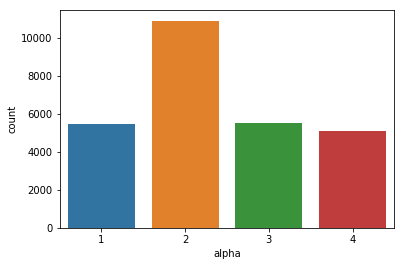

In [139]:
###frequency of sentiment_score
sns.countplot(train_factors_final['alpha'])

In [140]:
correlation = train_factors_final.corr()
correlation

,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,SF8
SF1,1.000000,0.003338,-0.385151,-0.156248,-0.202912,0.003960,0.814309,0.002482,0.000465
SF2,0.003338,1.000000,-0.007591,-0.015122,0.005073,-0.016984,0.011543,0.000762,0.004680
SF3,-0.385151,-0.007591,1.000000,0.262503,-0.823332,-0.013038,-0.529095,-0.044415,-0.000372
SF4,-0.156248,-0.015122,0.262503,1.000000,-0.117114,-0.006745,-0.690205,0.153574,0.033778
SF5,-0.202912,0.005073,-0.823332,-0.117114,1.000000,0.011143,0.026781,0.057072,0.002501
SF6,0.003960,-0.016984,-0.013038,-0.006745,0.011143,1.000000,0.008009,0.008481,-0.002025
SF7,0.814309,0.011543,-0.529095,-0.690205,0.026781,0.008009,1.000000,-0.077634,-0.018273
alpha,0.002482,0.000762,-0.044415,0.153574,0.057072,0.008481,-0.077634,1.000000,0.124899
SF8,0.000465,0.004680,-0.000372,0.033778,0.002501,-0.002025,-0.018273,0.124899,1.000000


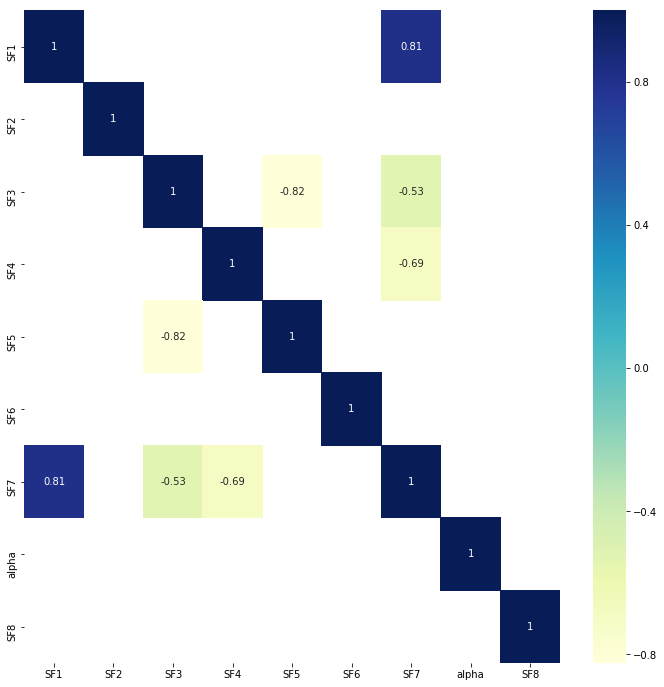

In [141]:
#Plotting a correlation heat map for train_factors_final data
plt.figure(figsize=(12,12))
sns.heatmap(correlation[(correlation>0.5) | (correlation < (-0.5))], cmap="YlGnBu", annot=True)
###showing high correlations among variables

### TRAIN TEST SPLIT FOR TRAIN_FACTORS(CSV)

In [142]:
#train test split.....
from sklearn.model_selection import train_test_split 
X=train_factors_final.copy().drop('alpha',axis=1)
Y=train_factors_final['alpha']
X_train,X_validation,Y_train,Y_validation = train_test_split(X,Y,test_size=0.3,random_state=1)
print(train_factors.shape)
print(X_train.shape)
print(X_validation.shape)
print(Y_train.shape)
print(Y_validation.shape)

(27006, 11)
(18904, 8)
(8102, 8)
(18904,)
(8102,)


In [143]:
X_train.head()

,SF1,SF2,SF3,SF4,SF5,SF6,SF7,SF8
4124,-0.325594,0.534377,-0.222709,0.966916,0.697487,-0.274297,-0.801253,2.500000
16402,-1.391800,-0.053202,0.104923,2.265053,0.810146,-2.623376,-2.595481,2.500000
19300,1.595782,0.461150,-0.798312,-1.872886,0.434691,-0.200140,2.727336,2.000000
11625,0.240146,1.370494,-0.214562,-1.632560,0.165506,-2.138633,1.243899,2.111111
20503,-0.721332,1.951899,0.593886,1.155938,-0.630606,-0.533401,-1.481241,2.652174


In [144]:
X_train.isnull().sum()###checking null values

SF1       0
SF2       0
SF3       0
SF4       0
SF5       0
SF6       0
SF7       0
SF8    1538
dtype: int64

### IMPUTATION 

In [145]:
#X_train['SF8'].value_counts()

In [146]:
#X_train['SF8'].fillna(X_train['SF8'].median(),inplace=True)

In [147]:
#X_train['SF8'].fillna(1,inplace=True)

In [148]:
X_train['SF8'].fillna(3,inplace=True)###fill na's with 3

In [149]:
X_train.isnull().sum()###checking null values

SF1    0
SF2    0
SF3    0
SF4    0
SF5    0
SF6    0
SF7    0
SF8    0
dtype: int64

In [150]:
#X_validation['SF8'].fillna(1,inplace=True)

In [151]:
X_validation['SF8'].fillna(3,inplace=True)###fill na's with 3

In [152]:
X_validation.isnull().sum()

SF1    0
SF2    0
SF3    0
SF4    0
SF5    0
SF6    0
SF7    0
SF8    0
dtype: int64

### PREPROCESSING ON TEST_FACTORS DATA(CSV) 

In [153]:
###reading the test_factors data
test_factors=pd.read_csv("C:\\Users\\mythr\\OneDrive\\Desktop\\3041\\PHD\\test_factors.csv")
test_factors.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7
0,270007,21/07/18,$INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449
1,270008,05/10/18,$CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353
2,270009,01/10/18,$CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811
3,270010,24/10/18,$CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803
4,270011,27/07/18,$intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111


In [154]:
test_factors.shape###shape(dimension) of the test_factors

(11575, 10)

In [155]:
test_factors.info()###gives information of the test_factors

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11575 entries, 0 to 11574
Data columns (total 10 columns):
Id        11575 non-null int64
date      11575 non-null object
ticker    11575 non-null object
SF1       11575 non-null float64
SF2       11575 non-null float64
SF3       11575 non-null float64
SF4       11575 non-null float64
SF5       11575 non-null float64
SF6       11575 non-null float64
SF7       11575 non-null float64
dtypes: float64(7), int64(1), object(2)
memory usage: 904.4+ KB


In [156]:
###showing the datatype,no of levels,levels of test_factors
def inspect_data(data):
    return pd.DataFrame({"Data Type":data.dtypes,"No of Levels":data.apply(lambda x: x.nunique(),axis=0), "Levels":data.apply(lambda x: str(x.unique()),axis=0)})
inspect_data(test_factors)

,Data Type,No of Levels,Levels
Id,int64,11575,[270007 270008 270009 ... 281579 281580 281581]
date,object,123,['21/07/18' '05/10/18' '01/10/18' '24/10/18' '...
ticker,object,1012,['$INTC' '$CTSH' '$CB' ... '$cof' '$JD' '$alb']
SF1,float64,11503,[-3.0621943910000002 0.816263353 0.40128090299...
SF2,float64,11503,[1.22346646 -2.184407942 0.091603924 ... 1.482...
SF3,float64,11503,[1.7417135369999999 0.157974539 0.083411039 .....
SF4,float64,11503,[2.279265877 -0.264742523 -1.147041258 ... 0.9...
SF5,float64,11503,[-1.323573287 -0.836282028 -0.48522347 ... -0....
SF6,float64,11503,[-0.274911986 0.04627575900000001 -0.601059978...
SF7,float64,11503,[-4.504449166000001 0.8263527159999999 1.01281...


In [157]:
###removing the slashes from the data
test_factors['date'] = test_factors['date'].apply(lambda x: '20'+x.split('/')[-1]+'-'+x.split('/')[1]+'-'+x.split('/')[0])
test_factors['date']=pd.to_datetime(test_factors['date']).dt.date
test_factors.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7
0,270007,2018-07-21,$INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449
1,270008,2018-10-05,$CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353
2,270009,2018-10-01,$CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811
3,270010,2018-10-24,$CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803
4,270011,2018-07-27,$intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111


In [158]:
###removing $ symbols and convert into lower case for ticker in the test_factors
test_factors["ticker"]=test_factors["ticker"].apply(lambda x: x.replace('$','')).str.lower()
test_factors.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7
0,270007,2018-07-21,intc,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449
1,270008,2018-10-05,ctsh,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353
2,270009,2018-10-01,cb,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811
3,270010,2018-10-24,ctas,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803
4,270011,2018-07-27,intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111


### ADDING (SF8)TEST PREDICTIONS OF JSON TO THE TEST_FACTORS (CSV DATA)

In [159]:
test_join=test_final[['date','ticker','SF8']].groupby(['date','ticker']).mean()

In [160]:
test_join.reset_index(level=['date','ticker'],inplace=True)
test_join.head()

,date,ticker,SF8
0,2018-07-01,aal,1.333333
1,2018-07-01,aapl,1.909091
2,2018-07-01,aep,2.000000
3,2018-07-01,aes,3.000000
4,2018-07-01,alxn,0.000000


In [161]:
test_factors_final=pd.merge(test_factors,test_join,how='left',left_on=['date','ticker'],right_on=['date','ticker'])
test_factors_final.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,SF8
0,270007,2018-07-21,intc,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,3.0
1,270008,2018-10-05,ctsh,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,3.0
2,270009,2018-10-01,cb,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811,2.0
3,270010,2018-10-24,ctas,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803,3.0
4,270011,2018-07-27,intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111,2.5


In [162]:
### dropping id,date,ticker
test_factors_final=test_factors_final.drop(["Id","date","ticker"],axis=True)
test_factors_final.head()

,SF1,SF2,SF3,SF4,SF5,SF6,SF7,SF8
0,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,3.0
1,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,3.0
2,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811,2.0
3,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803,3.0
4,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111,2.5


In [163]:
test_factors_final.isnull().sum()###checking null values

SF1     0
SF2     0
SF3     0
SF4     0
SF5     0
SF6     0
SF7     0
SF8    44
dtype: int64

### IMPUTATION 

In [164]:
#test_factors_final['SF8'].fillna(test_factors_final['SF8'].median(),inplace=True)

In [165]:
#test_factors_final['SF8'].fillna(1,inplace=True)

In [166]:
test_factors_final['SF8'].fillna(3,inplace=True)###fill na's with 3

In [167]:
test_factors_final.isnull().sum()

SF1    0
SF2    0
SF3    0
SF4    0
SF5    0
SF6    0
SF7    0
SF8    0
dtype: int64

In [168]:
###correlation between variables
correlation_test_factors=test_factors_final.corr()
correlation_test_factors

,SF1,SF2,SF3,SF4,SF5,SF6,SF7,SF8
SF1,1.000000,-0.003505,-0.394466,-0.166463,-0.185896,0.007151,0.815558,-0.000737
SF2,-0.003505,1.000000,-0.011076,-0.004447,0.013797,0.008609,0.001441,0.008782
SF3,-0.394466,-0.011076,1.000000,0.267560,-0.827421,0.002705,-0.536523,-0.038315
SF4,-0.166463,-0.004447,0.267560,1.000000,-0.119392,-0.001014,-0.695970,0.068313
SF5,-0.185896,0.013797,-0.827421,-0.119392,1.000000,-0.007304,0.041727,0.046768
SF6,0.007151,0.008609,0.002705,-0.001014,-0.007304,1.000000,0.005057,-0.002642
SF7,0.815558,0.001441,-0.536523,-0.695970,0.041727,0.005057,1.000000,-0.033415
SF8,-0.000737,0.008782,-0.038315,0.068313,0.046768,-0.002642,-0.033415,1.000000


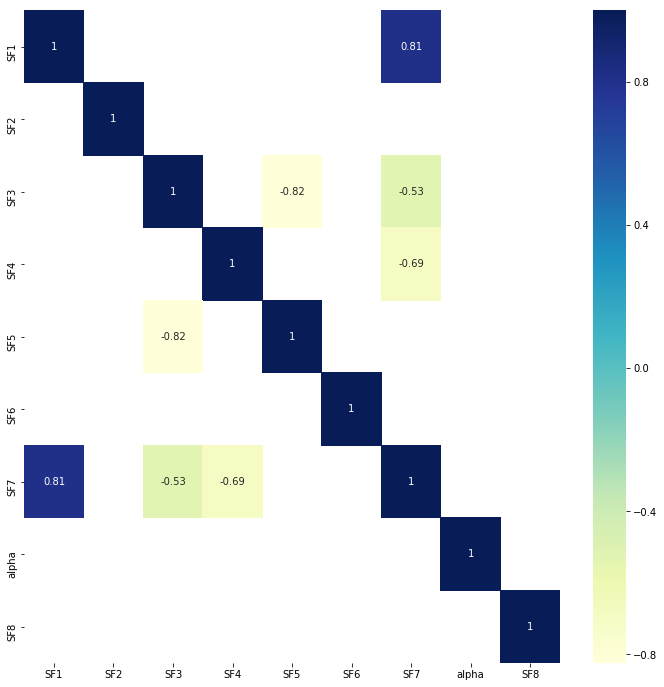

In [169]:
#Plotting a correlation heat map for train_factors_final data
plt.figure(figsize=(12,12))
sns.heatmap(correlation[(correlation>0.5) | (correlation < (-0.5))], cmap="YlGnBu", annot=True)
###showing high correlations among variables

### MODEL BUILDING 

In [170]:
##logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

lrc = LogisticRegression()

lrc.fit(X_train,Y_train)

y_pred_train_lrc = lrc.predict(X_train)
y_pred_val_lrc = lrc.predict(X_validation)

print(classification_report(Y_train,y_pred_train_lrc))
print(classification_report(Y_validation,y_pred_val_lrc))

              precision    recall  f1-score   support

           1       0.77      0.09      0.17      3801
           2       0.44      0.96      0.61      7705
           3       0.38      0.14      0.21      3853
           4       0.10      0.01      0.01      3545

   micro avg       0.44      0.44      0.44     18904
   macro avg       0.42      0.30      0.25     18904
weighted avg       0.43      0.44      0.33     18904

              precision    recall  f1-score   support

           1       0.79      0.10      0.18      1666
           2       0.43      0.97      0.59      3207
           3       0.37      0.14      0.20      1683
           4       0.14      0.01      0.01      1546

   micro avg       0.43      0.43      0.43      8102
   macro avg       0.43      0.30      0.25      8102
weighted avg       0.44      0.43      0.32      8102



([0.5703703703703704,
  0.5671957671957671,
  0.5554575912537472,
  0.555614336727946,
  0.5552264071096065,
  0.5559865984835126,
  0.5540356711003628,
  0.5536599880975996,
  0.5551049197672369,
  0.5573952602623783],
 [0.5657862256233029,
  0.5715872624043447,
  0.5651690940508517,
  0.5670204887682054,
  0.5660330782522834,
  0.5681313255986177,
  0.5646753887928907,
  0.5666502098247347,
  0.5668970624537152,
  0.5682547519131079])

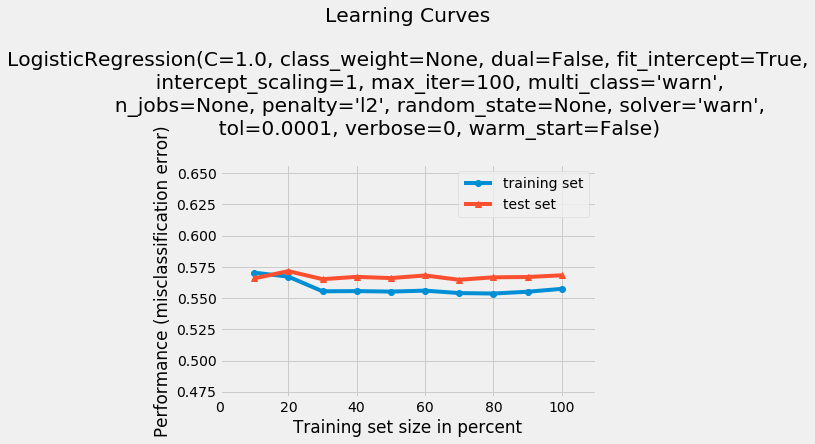

In [171]:
####LEARNING CURVE
#!pip install mlxtend
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(X_train, Y_train,X_validation,Y_validation,lrc)

### MODEL 1(A): DECISION TREE 

In [172]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz,DecisionTreeClassifier
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn import tree,ensemble
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

dtc = DecisionTreeClassifier()
dtc.fit(X_train,Y_train)
y_pred_train_dtc = dtc.predict(X_train)
y_pred_val_dtc = dtc.predict(X_validation)
y_pred_test_dtc = dtc.predict(test_factors_final)

pred_rfc_train=accuracy_score(Y_train, y_pred_train_dtc)
pred_rfc_test=accuracy_score(Y_validation, y_pred_val_dtc)

print(classification_report(Y_train,y_pred_train_dtc))
print(classification_report(Y_validation,y_pred_val_dtc))

y_pred_test_dtc

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3801
           2       1.00      1.00      1.00      7705
           3       1.00      1.00      1.00      3853
           4       1.00      1.00      1.00      3545

   micro avg       1.00      1.00      1.00     18904
   macro avg       1.00      1.00      1.00     18904
weighted avg       1.00      1.00      1.00     18904

              precision    recall  f1-score   support

           1       0.48      0.50      0.49      1666
           2       0.77      0.77      0.77      3207
           3       0.47      0.45      0.46      1683
           4       0.51      0.52      0.51      1546

   micro avg       0.60      0.60      0.60      8102
   macro avg       0.56      0.56      0.56      8102
weighted avg       0.60      0.60      0.60      8102



array([4, 2, 2, ..., 1, 2, 1], dtype=int64)

### MODEL 1(B): DECISION TREE WITH PARAMETERS TUNING 

In [173]:
dtc2 = DecisionTreeClassifier(criterion = "entropy", 
                                  random_state = 100,
                                  max_depth=13, 
                                  min_samples_leaf=10,
                                  min_samples_split=8,
                                 class_weight='balanced')
dtc2.fit(X_train,Y_train)
y_pred_train_dtc2 = dtc2.predict(X_train)
y_pred_val_dtc2 = dtc2.predict(X_validation)
y_pred_test_dtc2 = dtc2.predict(test_factors_final)

pred_rfc_train=accuracy_score(Y_train, y_pred_train_dtc2)
pred_rfc_test=accuracy_score(Y_validation, y_pred_val_dtc2)

print(classification_report(Y_train,y_pred_train_dtc2))
print(classification_report(Y_validation,y_pred_val_dtc2))

y_pred_test_dtc2

              precision    recall  f1-score   support

           1       0.69      0.68      0.68      3801
           2       0.83      0.82      0.82      7705
           3       0.70      0.61      0.65      3853
           4       0.61      0.71      0.66      3545

   micro avg       0.73      0.73      0.73     18904
   macro avg       0.71      0.71      0.70     18904
weighted avg       0.73      0.73      0.73     18904

              precision    recall  f1-score   support

           1       0.56      0.55      0.55      1666
           2       0.77      0.78      0.78      3207
           3       0.52      0.43      0.48      1683
           4       0.49      0.58      0.53      1546

   micro avg       0.62      0.62      0.62      8102
   macro avg       0.59      0.59      0.58      8102
weighted avg       0.62      0.62      0.62      8102



array([4, 3, 1, ..., 4, 2, 3], dtype=int64)

([0.29153439153439153,
  0.28386243386243387,
  0.27861047434314934,
  0.2815765110435128,
  0.2607913669064748,
  0.27393757714688766,
  0.2592956469165659,
  0.2613238114130794,
  0.2722036090048786,
  0.2703131612357173],
 [0.4744507529005184,
  0.44137250061713157,
  0.4213774376697112,
  0.400518390520859,
  0.3961984695137003,
  0.39360651690940507,
  0.3728708960750432,
  0.3836089854356949,
  0.3850901012095779,
  0.3779313749691434])

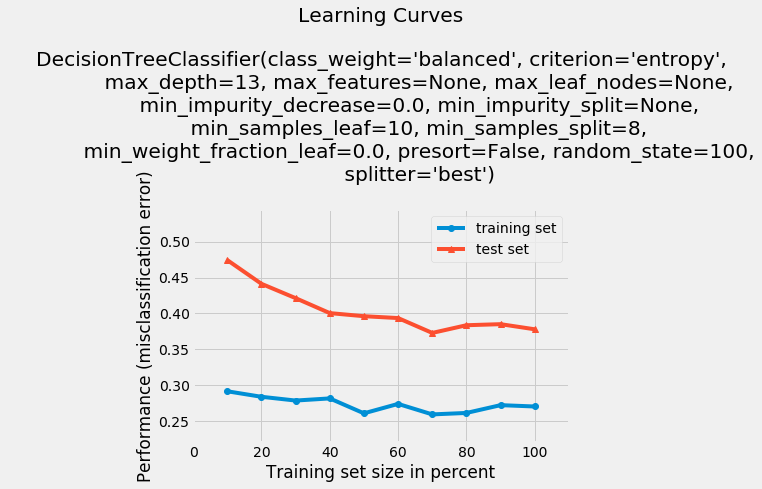

In [174]:
####LEARNING CURVE
#!pip install mlxtend
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(X_train, Y_train,X_validation,Y_validation,dtc2)

### MODEL 2 : XGBOOST CLASSIFIER

In [175]:
##xgboost
from xgboost import  XGBClassifier
X_classifier = XGBClassifier()
X_classifier.fit(X_train,Y_train)

xgboost_train_preds=X_classifier.predict(X_train)
xgboost_val_preds=X_classifier.predict(X_validation)
xgboost_test_preds=X_classifier.predict(test_factors_final)

print("Classification Report")
print(classification_report(Y_validation,xgboost_val_preds))
print("Classification Report")
print(classification_report(Y_train,xgboost_train_preds))

xgboost_test_preds

[15:36:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification Report
              precision    recall  f1-score   support

           1       0.71      0.54      0.61      1666
           2       0.74      0.95      0.83      3207
           3       0.66      0.51      0.57      1683
           4       0.65      0.60      0.62      1546

   micro avg       0.70      0.70      0.70      8102
   macro avg       0.69      0.65      0.66      8102
weighted avg       0.70      0.70      0.69      8102

Classification Report
              precision    recall  f1-score   support

           1       0.91      0.75      0.83      3801
           2       0.83      0.99      0.90      7705
           3       0.89      0.77      0.82    

array([4, 4, 2, ..., 4, 2, 2], dtype=int64)

[15:36:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

([0.0,
  0.00873015873015873,
  0.025745018515253043,
  0.050786932945377596,
  0.07204824375793482,
  0.0936342796684888,
  0.10655985489721886,
  0.11657739866428618,
  0.1276082995356492,
  0.14097545493017352],
 [0.3768205381387312,
  0.35016045420883735,
  0.3346087385830659,
  0.3243643544803752,
  0.3236237965934337,
  0.313873117748704,
  0.3107874598864478,
  0.3032584547025426,
  0.3037521599605036,
  0.29511231794618614])

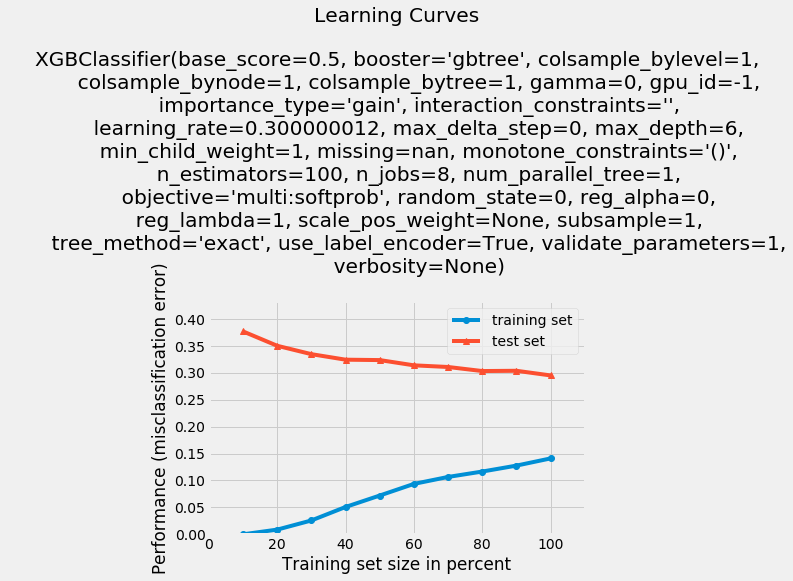

In [176]:
####LEARNING CURVE
#!pip install mlxtend
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(X_train, Y_train,X_validation,Y_validation,X_classifier)

### MODEL 3(A): RANDOM FOREST CLASSIFER

In [177]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X = X_train,y = Y_train)

train_predictions = rfc.predict(X_train)
validation_predictions = rfc.predict(X_validation)
test_predictions = rfc.predict(test_factors_final)

print("Classification Report")
print(classification_report(Y_train,train_predictions))
print("Classification Report")
print(classification_report(Y_validation,validation_predictions))

test_predictions

Classification Report
              precision    recall  f1-score   support

           1       0.98      0.99      0.99      3801
           2       0.98      1.00      0.99      7705
           3       0.99      0.97      0.98      3853
           4       0.99      0.98      0.98      3545

   micro avg       0.99      0.99      0.99     18904
   macro avg       0.99      0.98      0.99     18904
weighted avg       0.99      0.99      0.99     18904

Classification Report
              precision    recall  f1-score   support

           1       0.60      0.56      0.58      1666
           2       0.74      0.91      0.82      3207
           3       0.59      0.46      0.52      1683
           4       0.61      0.51      0.56      1546

   micro avg       0.67      0.67      0.67      8102
   macro avg       0.64      0.61      0.62      8102
weighted avg       0.66      0.67      0.66      8102



array([4, 2, 2, ..., 4, 2, 1], dtype=int64)

### MODEL 3(B): RANDOM FOREST CLASSIFER WITH PARAMETER TUNING 

In [178]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rfc.fit(X = X_train,y = Y_train)
train_predictions2 = rfc.predict(X_train)
validation_predictions2 = rfc.predict(X_validation)
test_predictions2 = rfc.predict(test_factors_final)

print(classification_report(Y_train,train_predictions2))
print(classification_report(Y_validation,validation_predictions2))

test_predictions2

              precision    recall  f1-score   support

           1       0.78      0.56      0.65      3801
           2       0.74      0.97      0.84      7705
           3       0.75      0.59      0.66      3853
           4       0.72      0.62      0.67      3545

   micro avg       0.74      0.74      0.74     18904
   macro avg       0.75      0.68      0.70     18904
weighted avg       0.75      0.74      0.73     18904

              precision    recall  f1-score   support

           1       0.71      0.49      0.58      1666
           2       0.69      0.94      0.80      3207
           3       0.63      0.46      0.53      1683
           4       0.62      0.52      0.57      1546

   micro avg       0.67      0.67      0.67      8102
   macro avg       0.66      0.60      0.62      8102
weighted avg       0.67      0.67      0.65      8102



array([4, 4, 2, ..., 4, 2, 2], dtype=int64)

([0.30846560846560844,
  0.28809523809523807,
  0.27490742373479105,
  0.2739055680465547,
  0.2657638595006348,
  0.2654734614706401,
  0.25597037484885127,
  0.25960457581167756,
  0.2549814847469582,
  0.25280363944138806],
 [0.4150826956307085,
  0.37978276968649716,
  0.3592940014811158,
  0.3510244384102691,
  0.3468279437176006,
  0.34152061219451985,
  0.3406566279930881,
  0.3421377437669711,
  0.3333744754381634,
  0.32621574919772894])

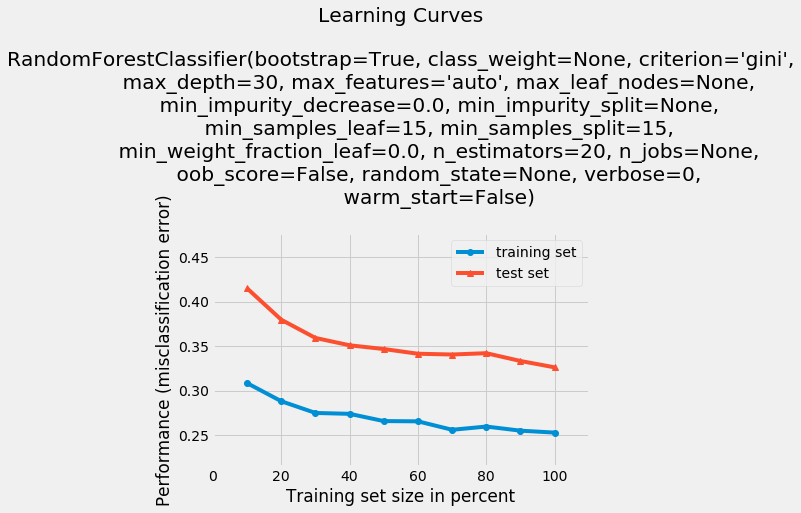

In [179]:
####LEARNING CURVE
#!pip install mlxtend
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(X_train, Y_train,X_validation,Y_validation,rfc)

In [180]:
#from sklearn.metrics import accuracy_score,f1_score
#print("\nTrain accuracy",accuracy_score(y_train,train_predictions))
#print("\nTrain f1-score for class 'yes'",f1_score(y_train,train_predictions,pos_label="yes"))
#print("\nTrain f1-score for class 'no'",f1_score(y_train,train_predictions,pos_label="no"))

In [181]:
#print("\nTest accuracy",accuracy_score(y_test,test_predictions))
#print("\nTest f1-score for class 'yes'",f1_score(y_test,test_predictions,pos_label="yes"))
#print("\nTest f1-score for class 'no'",f1_score(y_test,test_predictions,pos_label="no"))

### MODEL 4(A): MLP CLASSIFIER

In [182]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

model = MLPClassifier()

model.fit(X_train,Y_train)
sklearn_mlp_train_preds = model.predict(X_train)
sklearn_mlp_validation_preds = model.predict(X_validation)
sklearn_mlp_test_preds = model.predict(test_factors_final)

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(Y_train,sklearn_mlp_train_preds))
print(classification_report(Y_validation,sklearn_mlp_validation_preds))

print("Train Accuracy  :  ",accuracy_score(Y_train,sklearn_mlp_train_preds))
print("Test Accuracy   :  ",accuracy_score(Y_validation,sklearn_mlp_validation_preds))

sklearn_mlp_test_preds

              precision    recall  f1-score   support

           1       0.72      0.61      0.66      3801
           2       0.83      0.97      0.90      7705
           3       0.68      0.59      0.63      3853
           4       0.73      0.68      0.71      3545

   micro avg       0.77      0.77      0.77     18904
   macro avg       0.74      0.71      0.72     18904
weighted avg       0.76      0.77      0.76     18904

              precision    recall  f1-score   support

           1       0.70      0.59      0.64      1666
           2       0.82      0.97      0.89      3207
           3       0.66      0.55      0.60      1683
           4       0.71      0.69      0.70      1546

   micro avg       0.75      0.75      0.75      8102
   macro avg       0.72      0.70      0.71      8102
weighted avg       0.74      0.75      0.74      8102

Train Accuracy  :   0.7676682183664832
Test Accuracy   :   0.7515428289311281


array([4, 3, 2, ..., 4, 2, 1], dtype=int64)

([0.2788359788359788,
  0.2706349206349206,
  0.2650326221125022,
  0.2535378918132522,
  0.25021159542953875,
  0.24254981484746957,
  0.23715235792019346,
  0.23745288633207698,
  0.23811203197554812,
  0.23037452391028354],
 [0.32745001234263144,
  0.3052332757343866,
  0.28708960750431994,
  0.27943717600592444,
  0.270797333991607,
  0.26166378671932855,
  0.25191310787459886,
  0.2537645025919526,
  0.2547519131078746,
  0.24845717106887188])

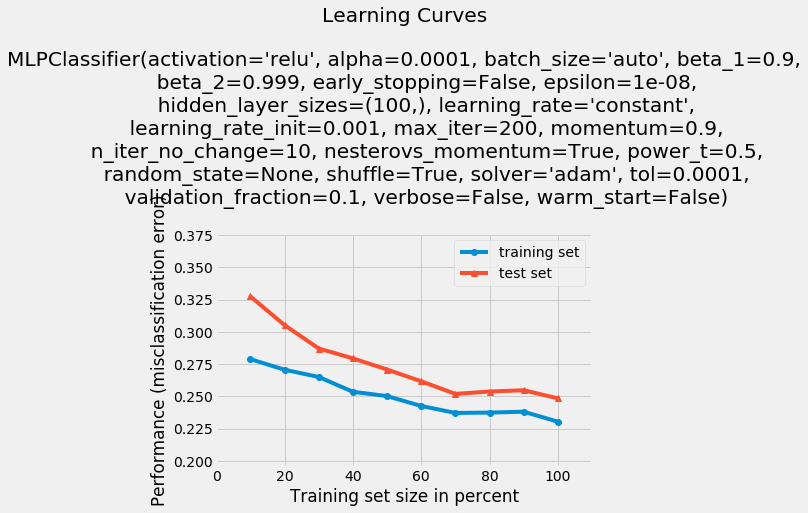

In [183]:
####LEARNING CURVE
#!pip install mlxtend
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(X_train, Y_train,X_validation,Y_validation,model)

### MODEL 4(B): MLP CLASSIFIER WITH TUNING

In [184]:
from sklearn.neural_network import MLPClassifier
model1 = MLPClassifier(activation='relu',batch_size=20,random_state=1234,hidden_layer_sizes=(100,),max_iter=200)
model1.fit(X_train,Y_train)

from sklearn.metrics import accuracy_score
sklearn_mlp_train_preds1 = model.predict(X_train)
sklearn_mlp_validation_preds1 = model.predict(X_validation)
sklearn_mlp_test_preds1 = model.predict(test_factors_final)

print("Train Accuracy  :  ",accuracy_score(Y_train,sklearn_mlp_train_preds1))
print("Test Accuracy   :  ",accuracy_score(Y_validation,sklearn_mlp_validation_preds1))


from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(Y_train,sklearn_mlp_train_preds1))
print(classification_report(Y_validation,sklearn_mlp_validation_preds1))

sklearn_mlp_test_preds1

Train Accuracy  :   0.7696254760897164
Test Accuracy   :   0.7515428289311281
              precision    recall  f1-score   support

           1       0.75      0.57      0.64      3801
           2       0.84      0.97      0.90      7705
           3       0.68      0.60      0.64      3853
           4       0.69      0.73      0.71      3545

   micro avg       0.77      0.77      0.77     18904
   macro avg       0.74      0.72      0.72     18904
weighted avg       0.76      0.77      0.76     18904

              precision    recall  f1-score   support

           1       0.73      0.55      0.63      1666
           2       0.83      0.97      0.89      3207
           3       0.65      0.56      0.60      1683
           4       0.68      0.72      0.70      1546

   micro avg       0.75      0.75      0.75      8102
   macro avg       0.72      0.70      0.71      8102
weighted avg       0.74      0.75      0.74      8102



array([4, 1, 2, ..., 4, 2, 2], dtype=int64)

### MODEL 4(C): MLP CLSSIFIER WITH PARAMETER TUNING 

In [185]:
from sklearn.neural_network import MLPClassifier
model2 = MLPClassifier(activation='relu',batch_size=32,random_state=1234,hidden_layer_sizes=(60,),max_iter=250)
model2.fit(X_train,Y_train)

from sklearn.metrics import accuracy_score
sklearn_mlp_train_preds2 = model2.predict(X_train)
sklearn_mlp_validation_preds2 = model2.predict(X_validation)
sklearn_mlp_test_preds2 = model2.predict(test_factors_final)

print("Train Accuracy  :  ",accuracy_score(Y_train,sklearn_mlp_train_preds2))
print("Test Accuracy   :  ",accuracy_score(Y_validation,sklearn_mlp_validation_preds2))

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(Y_train,sklearn_mlp_train_preds2))
print(classification_report(Y_validation,sklearn_mlp_validation_preds2))

sklearn_mlp_test_preds2

Train Accuracy  :   0.7775074058400339
Test Accuracy   :   0.7640088866946433
              precision    recall  f1-score   support

           1       0.67      0.69      0.68      3801
           2       0.87      0.97      0.91      7705
           3       0.74      0.53      0.61      3853
           4       0.71      0.74      0.72      3545

   micro avg       0.78      0.78      0.78     18904
   macro avg       0.75      0.73      0.73     18904
weighted avg       0.77      0.78      0.77     18904

              precision    recall  f1-score   support

           1       0.66      0.67      0.67      1666
           2       0.86      0.97      0.91      3207
           3       0.71      0.50      0.58      1683
           4       0.70      0.74      0.72      1546

   micro avg       0.76      0.76      0.76      8102
   macro avg       0.73      0.72      0.72      8102
weighted avg       0.76      0.76      0.76      8102



array([4, 1, 2, ..., 4, 2, 2], dtype=int64)

### MODEL 4(D): MLP CLASSIFIER WITH PARAMETER TUNING

In [186]:
from sklearn.neural_network import MLPClassifier
model3 = MLPClassifier(activation='relu',batch_size=6,random_state=1234,hidden_layer_sizes=(55,),max_iter=250)
model3.fit(X_train,Y_train)

from sklearn.metrics import accuracy_score
sklearn_mlp_train_preds3 = model3.predict(X_train)
sklearn_mlp_validation_preds3 = model3.predict(X_validation)
sklearn_mlp_test_preds3 = model3.predict(test_factors_final)

print("Train Accuracy  :  ",accuracy_score(Y_train,sklearn_mlp_train_preds3))
print("Test Accuracy   :  ",accuracy_score(Y_validation,sklearn_mlp_validation_preds3))

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(Y_train,sklearn_mlp_train_preds3))
print(classification_report(Y_validation,sklearn_mlp_validation_preds3))

sklearn_mlp_test_preds3

Train Accuracy  :   0.7787769784172662
Test Accuracy   :   0.7635151814366823
              precision    recall  f1-score   support

           1       0.69      0.66      0.67      3801
           2       0.87      0.96      0.91      7705
           3       0.69      0.60      0.64      3853
           4       0.73      0.72      0.72      3545

   micro avg       0.78      0.78      0.78     18904
   macro avg       0.75      0.73      0.74     18904
weighted avg       0.77      0.78      0.77     18904

              precision    recall  f1-score   support

           1       0.67      0.64      0.65      1666
           2       0.86      0.96      0.91      3207
           3       0.67      0.57      0.62      1683
           4       0.72      0.70      0.71      1546

   micro avg       0.76      0.76      0.76      8102
   macro avg       0.73      0.72      0.72      8102
weighted avg       0.76      0.76      0.76      8102



array([4, 4, 2, ..., 4, 2, 1], dtype=int64)

##### MLP CLASSIFIER GIVES MORE ACCURACY,F1 SCORE COMPARED TO OTHER MODELS

([0.23544973544973544,
  0.24074074074074073,
  0.2269441015693881,
  0.22708636423753473,
  0.2277824798984342,
  0.22403456180567802,
  0.22861245465538088,
  0.22297163261257688,
  0.22365250102862516,
  0.22122302158273383],
 [0.30091335472722786,
  0.28067143915082693,
  0.2547519131078746,
  0.24981486052826463,
  0.24487780794865466,
  0.2379659343372007,
  0.24512466057763516,
  0.2374722290792397,
  0.24314983954579117,
  0.2364848185633177])

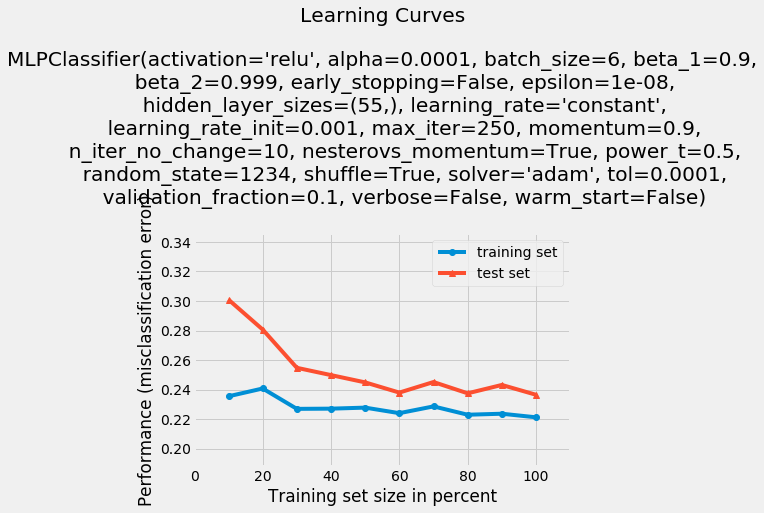

In [187]:
####LEARNING CURVE
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(X_train, Y_train,X_validation,Y_validation,model3)

### EVALUATION METRIC 

### f1 score

##### The average of the F1-score for each of the classes
##### Eval Metric = (F1 score for target level 1 + level 2 + level 3 + level 4) / 4

##### for train macro avg f1 score: 0.74
##### for validation macro avg f1 score: 0.72

In [188]:
test_factors1=pd.read_csv("C:\\Users\\mythr\\OneDrive\\Desktop\\3041\\PHD\\test_factors.csv")

In [189]:
samplesubmission = pd.DataFrame({'Id':test_factors1['Id'],'alpha':sklearn_mlp_test_preds3})


In [191]:
##file conversion
filename = 'C:\\Users\\mythr\\OneDrive\\Desktop\\3041\\PHD.csv'

samplesubmission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: C:\Users\mythr\OneDrive\Desktop\3041\PHD.csv
